In [9]:
"!git clone https://github.com/Ludostck/Projet.git"
path = "./Images/"

In [10]:
IMAGE_SIZE = 128
CLASSES = ['Galaxie', 'Nébuleuses', 'Comètes','Amas','Lunes']

In [11]:
import glob
import PIL
from PIL import Image
import numpy as np
import os
import shutil
from scipy.io import loadmat

def load_data(data_path, classes, dataset='train', image_size=64):
    num_images = 0
    for class_name in classes:
        dir_path = os.path.join(data_path, dataset, class_name)
        num_images += len([item for item in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, item))])
    
    x = np.zeros((num_images, image_size, image_size, 3), dtype=np.uint8)
    y = np.zeros((num_images, 1), dtype=int)
    
    current_index = 0
    
    for idx_class, class_name in enumerate(classes):
        dir_path = os.path.join(data_path, dataset, class_name)
        for item in sorted(os.listdir(dir_path)):
            file_path = os.path.join(dir_path, item)
            if os.path.isfile(file_path):
                with Image.open(file_path) as img:
                    img = img.convert('RGB').resize((image_size, image_size), Image.Resampling.LANCZOS)
                    x[current_index] = np.asarray(img, dtype=np.uint8)
                    y[current_index] = idx_class
                    current_index += 1
                
    return x, y


x_train, y_train = load_data(path, CLASSES, dataset='train', image_size=IMAGE_SIZE)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

x_val, y_val = load_data(path, CLASSES, dataset='validation', image_size=IMAGE_SIZE)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)

x_test, y_test = load_data(path, CLASSES, dataset='test', image_size=IMAGE_SIZE)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)
# Normalisation des entrées via une division par 255 des valeurs de pixel.
x_train = x_train/255
x_val = x_val/255
x_test = x_test/255



x_train shape: (6117, 128, 128, 3)
y_train shape: (6117, 1)
x_val shape: (711, 128, 128, 3)
y_val shape: (711, 1)
x_test shape: (358, 128, 128, 3)
y_test shape: (358, 1)


C:\Users\ludos\AppData\Local\Temp\ipykernel_14840\46290205.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(CLASSES[int(y_train[image_index])])


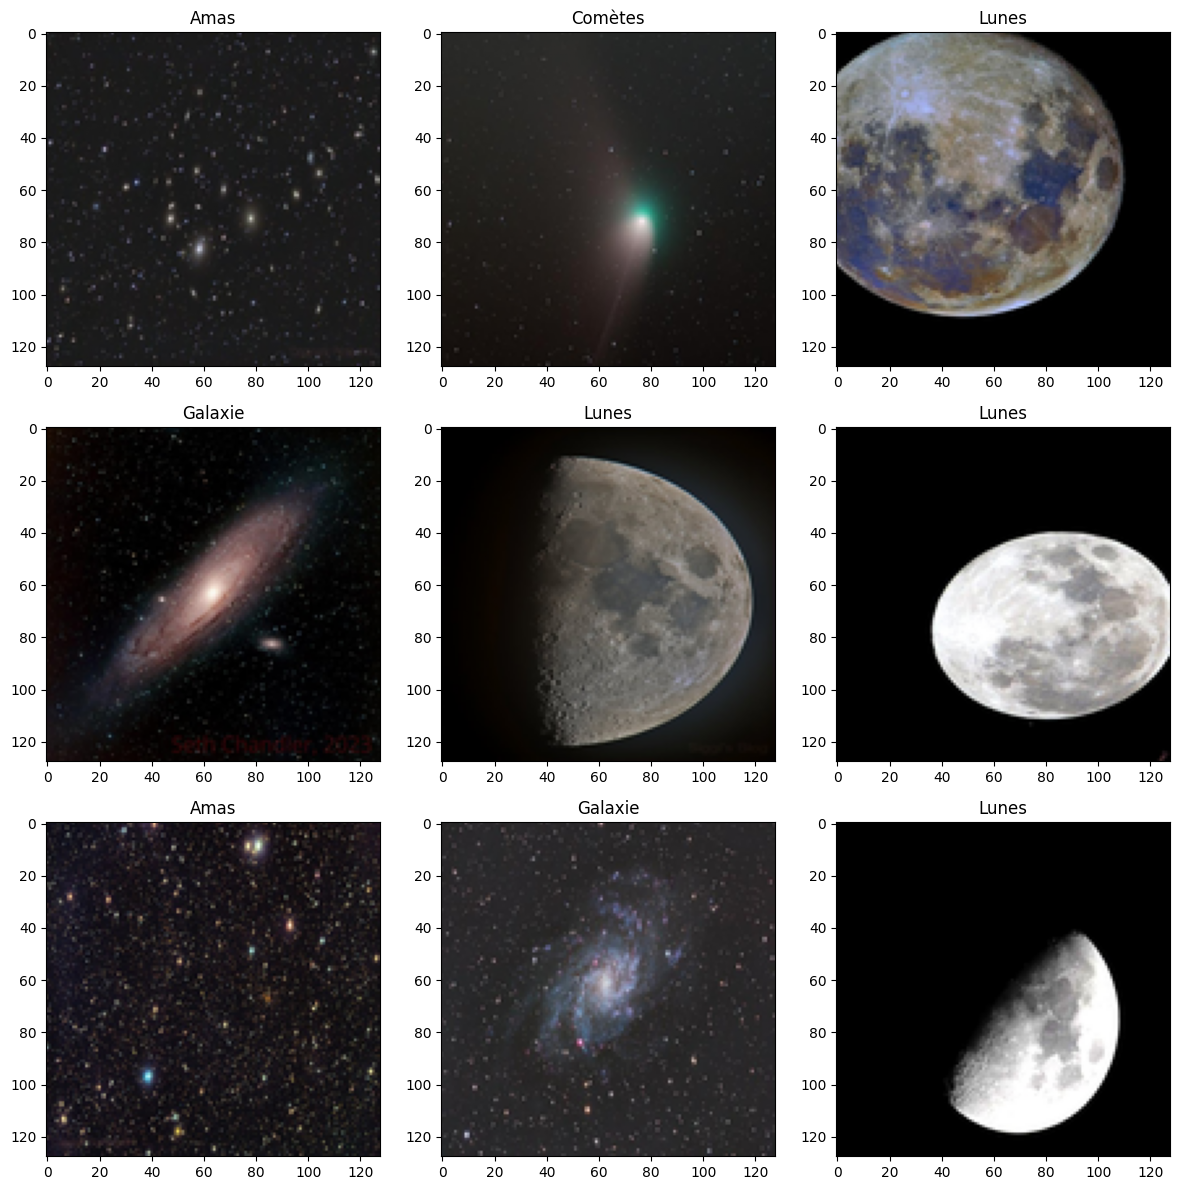

In [12]:
import matplotlib.pyplot as plt
import numpy as np

num_images = 9  # Choix aléatoire entre 1 et 9 images

plt.figure(figsize=(12, 12))

# Générer des indices aléatoires basés sur la taille de x_train
shuffle_indices = np.random.permutation(len(x_train))

for i in range(num_images):
    plt.subplot(3, 3, i+1)  # S'assurer de ne pas dépasser 9
    # Utiliser un index aléatoire pour sélectionner l'image
    image_index = shuffle_indices[i]
    image = x_train[image_index]
    # Afficher le titre basé sur l'étiquette de l'image choisie
    plt.title(CLASSES[int(y_train[image_index])])
    # Normaliser l'image pour l'affichage
    plt.imshow(image)

plt.tight_layout()
plt.show()

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import optimizers

model = Sequential()

# Première couche de convolution et pooling
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(BatchNormalization())  # Ajout de la normalisation par batch
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))  # Ajout d'un dropout pour réduire le sur-ajustement

# Deuxième couche de convolution et pooling
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Troisième couche de convolution et pooling
model.add(Conv2D(96, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Quatrième couche de convolution et pooling
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))  # Augmentation du taux de dropout pour les couches plus profondes

# Vectorisation des features et couches denses
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Haut taux de dropout avant la couche finale pour minimiser le sur-ajustement
model.add(Dense(5, activation='softmax'))  # 5 classes

In [14]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16, 16, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 128)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,386,213 (16.73 MB)

 Trainable params: 4,384,549 (16.73 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [15]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=3e-4),
              metrics=['accuracy'])

In [16]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=9, batch_size=10)  # Augmentation du nombre d'époques et ajustement de la taille des batchsà


Epoch 1/9
612/612 ━━━━━━━━━━━━━━━━━━━━ 136s 216ms/step - accuracy: 0.6707 - loss: 1.0995 - val_accuracy: 0.4149 - val_loss: 3.6548
Epoch 2/9
612/612 ━━━━━━━━━━━━━━━━━━━━ 115s 188ms/step - accuracy: 0.8095 - loss: 0.5775 - val_accuracy: 0.6934 - val_loss: 1.0173
Epoch 3/9
612/612 ━━━━━━━━━━━━━━━━━━━━ 118s 193ms/step - accuracy: 0.8605 - loss: 0.4426 - val_accuracy: 0.8664 - val_loss: 0.4567
Epoch 4/9
612/612 ━━━━━━━━━━━━━━━━━━━━ 116s 189ms/step - accuracy: 0.8827 - loss: 0.3523 - val_accuracy: 0.8959 - val_loss: 0.3850
Epoch 5/9
612/612 ━━━━━━━━━━━━━━━━━━━━ 114s 186ms/step - accuracy: 0.9016 - loss: 0.3192 - val_accuracy: 0.9142 - val_loss: 0.2465
Epoch 6/9
612/612 ━━━━━━━━━━━━━━━━━━━━ 113s 185ms/step - accuracy: 0.9028 - loss: 0.3116 - val_accuracy: 0.9114 - val_loss: 0.2535
Epoch 7/9
612/612 ━━━━━━━━━━━━━━━━━━━━ 112s 182ms/step - accuracy: 0.9080 - loss: 0.2844 - val_accuracy: 0.9381 - val_loss: 0.1560
Epoch 8/9
612/612 ━━━━━━━━━━━━━━━━━━━━ 120s 197ms/step - accuracy: 0.9254 - loss: 0

In [17]:
model.save("Projet.keras")


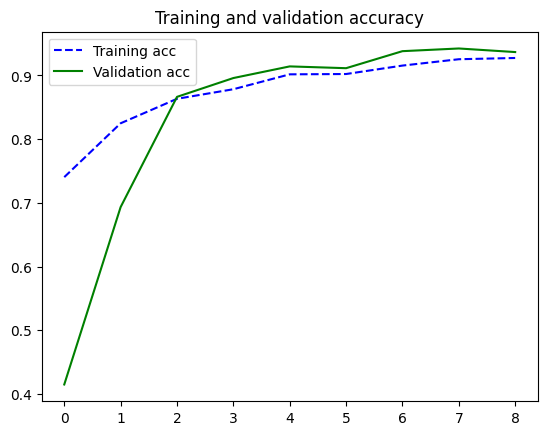

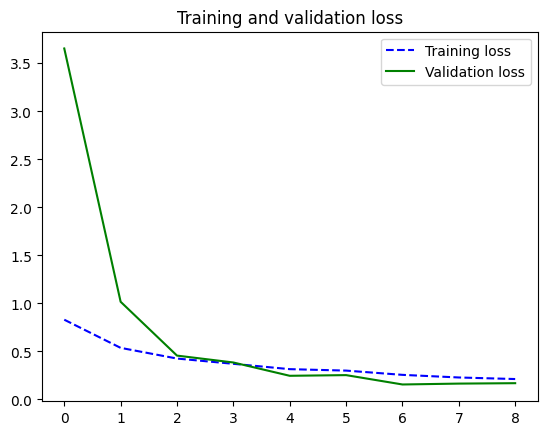

In [18]:
def plot_training_analysis():
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', linestyle="--",label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
  plt.plot(epochs, val_loss,'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()
plot_training_analysis()

In [19]:
# Effectuer une prédiction avec le modèle sur x_test
predictions_t = model.predict(x_test)

# Convertir les prédictions en étiquettes réelles
# Utilisez np.argmax pour convertir les prédictions de one-hot encoding vers des étiquettes
predictions_t_labels = np.argmax(predictions_t, axis=1)  # Correction ici : utiliser axis=1

# Calculer la précision sur le jeu de test
# Assurez-vous que y_test est de la bonne forme; il devrait être un vecteur simple de labels.
accuracy_t = np.mean(predictions_t_labels == y_test.flatten()) * 100
print(f'Précision sur le jeu de test : {accuracy_t:.2f}%') 

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
Précision sur le jeu de test : 91.90%


In [20]:
from sklearn.metrics import classification_report
predictions_val = model.predict(x_val)

predictions_val_labels = np.argmax(predictions_val, axis=1)  # Correction ici : utiliser axis=1

# Générez le rapport de classification
report_val = classification_report(y_val, predictions_val_labels, target_names=CLASSES, output_dict=False)
report_t = classification_report(y_test, predictions_t_labels, target_names=CLASSES, output_dict=False)

print(report_val)
print()
print(report_t)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step
              precision    recall  f1-score   support

     Galaxie       0.90      0.90      0.90       145
  Nébuleuses       0.87      0.97      0.92       160
     Comètes       0.97      0.96      0.96       178
        Amas       1.00      0.88      0.94       129
       Lunes       0.99      0.98      0.98        99

    accuracy                           0.94       711
   macro avg       0.94      0.94      0.94       711
weighted avg       0.94      0.94      0.94       711


              precision    recall  f1-score   support

     Galaxie       0.87      0.93      0.90        73
  Nébuleuses       0.86      0.93      0.89        80
     Comètes       0.98      0.91      0.94        88
        Amas       0.95      0.89      0.92        64
       Lunes       0.96      0.94      0.95        53

    accuracy                           0.92       358
   macro avg       0.92      0.92      0.92       358
weighted avg       0.92      0.92   

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


C:\Users\ludos\AppData\Local\Temp\ipykernel_14840\3703928914.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_label = CLASSES[int(y_test[image_index])]


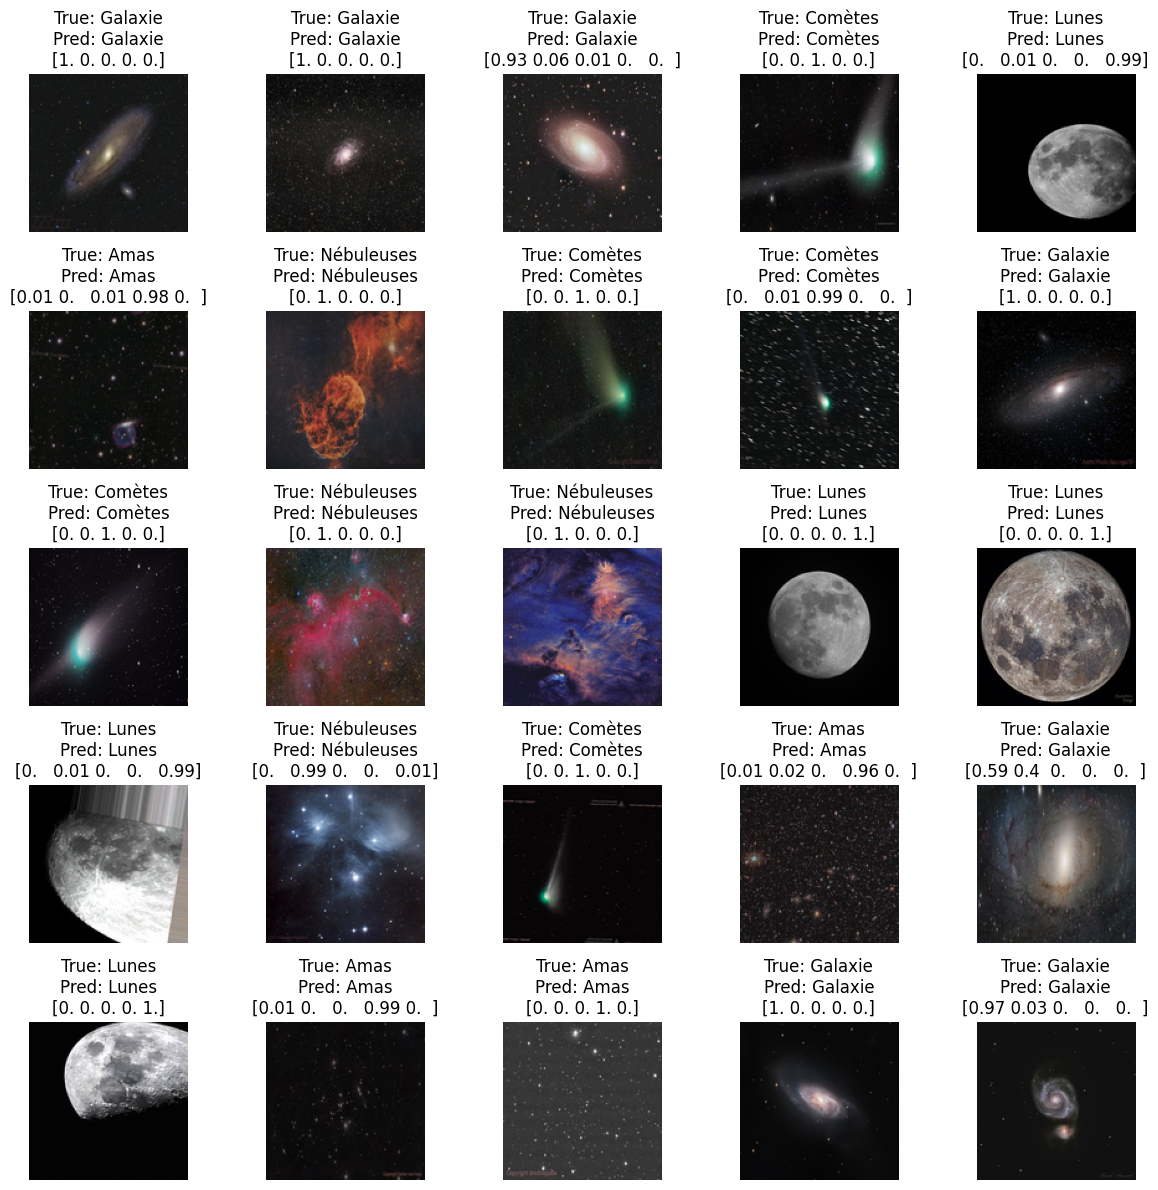

In [21]:
num_images = 25  # Choix aléatoire entre 1 et 9 images
shuffle_indices = np.random.permutation(len(x_test))

predictions = model.predict(x_test[shuffle_indices[:num_images]])

plt.figure(figsize=(12, 12))

for i in range(num_images):
    plt.subplot(5, 5, i+1)
    image_index = shuffle_indices[i]
    image = x_test[image_index]
    
    true_label = CLASSES[int(y_test[image_index])]
    
    # Obtenir la classe prédite et les probabilités
    predicted_label = CLASSES[np.argmax(predictions[i])]
    probs = predictions[i]
    
    # Afficher l'image avec le titre indiquant la vraie classe et la classe prédite
    plt.title(f"True: {true_label}\nPred: {predicted_label}\n{np.round(probs, 2)}")
    plt.imshow(image)
    plt.axis('off')  # Enlève les axes pour une meilleure clarté

plt.tight_layout()
plt.show()

In [32]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import numpy as np
from tensorflow.keras.models import load_model

# Assurez-vous que le modèle est chargé correctement, adaptez le chemin au besoin.
IMAGE_SIZE = 128
def load_image():
    # Choix de l'image
    file_path = filedialog.askopenfilename()
    if not file_path:  # Vérifie si le chemin n'est pas vide
        return
    
    # Chargement et affichage de l'image choisie
    img = Image.open(file_path)
    img = img.resize((600, 600), Image.Resampling.LANCZOS)  # Redimensionnement de l'image
    img_tk = ImageTk.PhotoImage(img)
    panel.configure(image=img_tk)
    panel.image = img_tk  # Garde une référence
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE), Image.Resampling.LANCZOS)
    classify_image(img)  # Classifie l'image

def classify_image(img):
    # Prétraitement de l'image pour la classification
    img_array = np.array(img) / 255.0  # Normalisation
    img_array = img_array.reshape((1, IMAGE_SIZE, IMAGE_SIZE, 3))  # Ajout de la dimension du batch

    # Prédiction
    predictions = model.predict(img_array)
    predicted_class = CLASSES[np.argmax(predictions)]  # Remplacer CLASSES par vos classes réelles
    prob = np.max(predictions)
    
    # Affichage de la classe prédite et de la probabilité
    result_label.config(text=f'Predicted: {predicted_class} ({prob:.2f})')

# Création de la fenêtre Tkinter
root = tk.Tk()
root.title('Image Classifier')

# Ajout d'un bouton pour charger une image
btn_load = tk.Button(root, text='Load Image', command=load_image)
btn_load.pack()

# Panneau pour afficher l'image choisie
panel = tk.Label(root)
panel.pack()

# Étiquette pour afficher la prédiction
result_label = tk.Label(root, text='Prediction will appear here', font=('Arial', 16))
result_label.pack()

# Lancement de l'application
root.mainloop()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [36]:
import os
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
from PIL import UnidentifiedImageError


# Dossier contenant les images à classifier
image_folder = 'Lunes_2'

# Dossier pour sauvegarder les images classifiées comme Nébuleuse
save_folder = 'Lu_att'


if not os.path.exists(save_folder):
    os.makedirs(save_folder)

# Parcourir toutes les images dans le dossier
for image_name in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_name)
    
    try:
        # Charger l'image, ajuster les dimensions et prétraiter
        img = Image.open(image_path)
        img_array = np.array(img) / 255.0  # Normalisation
        img_array = img_array.reshape((1, IMAGE_SIZE, IMAGE_SIZE, 3))  # Ajout de la dimension du batch
        
        # Prédire la classe de l'image
        predictions = model.predict(img_array)
        predicted_class = CLASSES[np.argmax(predictions)]  # Remplacer CLASSES par vos classes réelles
        prob = np.max(predictions)
        
        # Vérifier si l'image est classifiée comme Nébuleuse avec proba >= 0.95
        if predicted_class == "Lunes"  and prob >= 0.98 :
            # Sauvegarder l'image dans le nouveau dossier
            print(predicted_class)
            print(prob)
            save_path = os.path.join(save_folder, image_name)
            image.save(save_path)
        else:
            # Supprimer l'image si elle ne correspond pas à la classification désirée
            os.remove(image_path)

    except UnidentifiedImageError:
        print(f"Erreur : Impossible d'identifier ou de lire l'image {image_name}. Elle sera supprimée.")
        os.remove(image_path)
    except Exception as e:
        print(f"Erreur inattendue avec l'image {image_name}: {e}")

print("Classification et nettoyage terminés.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Lunes
0.9999001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Lunes
0.9992318
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Lunes
0.99006724
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Lunes
0.99999714
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Lunes
0.9999895
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━